# Are we rich yet?
## Predicting a selected sector of the U.S. stock market
### by Market Predictors (Yvan Gauthier, Eric Arnold, Raghu Dhara, and Lin Sang)
### TF: Sail Wu

In [1]:
%matplotlib inline
import talib, time, datetime
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.finance as finance
import matplotlib.mlab as mlab
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Background and Motivation

Our main goal for this project is to produce an algorithm generating daily, binary buy/sell prediction on how a selected sector of the U.S. stock market will perform over the near term (i.e., up or down). If we can identify peaks and troughs, we can sell when the sector is at a high and buy when the sector is at a low. Our hope is that our model will produce predictions that outperform the sector’s index (which would serve as a benchmark).

Note that we decided to predict specific sectors of the U.S. market instead of predicting the stock market as a whole or individual stocks. We believe that limiting our analysis to a few sectors will allow us to find more meaningful patterns in the data and to identify a richer set of features for our predictions. By avoiding individual stocks, we avoid extreme good/bad news (earnings surprises, leadership shake-ups, fraud, litigation, etc).

### Design Overview

Technical Analysis is widely used by traders around the world to predict short-term price movement in the financial markets. There are hundreds of different technical indicators based on mathematical calculation of historical price and volume data, and professional traders often combine multiple indicators in the technical analysis. 

Since our objective is to generate daily prediction of the direction of market rather than quantifying the market fluctuation, our approach is to simplify the prediction as a Machine Learning classification problem. By using technical indicators that analyze and compare various rolling periods of pricing data, each indicator has between 3 and 200 days of data used to calculate each measurement. This approach allows us to predict based on the indicators instead of attempting to predict a time-series-based trend.

Technical Analysis algorithms all use basic historical pricing data to calculate some measurement. Each measurement has a unique interpretation (provided by the author(s) of the algorithms) which we've converted into signals. Each technical indicator's measurement and signal are potential features for our machine learning algorithm. In addition, we also include market sentiment as one of the potential features in our machine learning. Sentiment analysis is done using New York Time articles released over the same time period(s).

We select the most effective indicators through a feature engineering process and train a number of classifiers using historical data from 2010-2014. Then we make daily predictions for the sector's trend throughout 2015 (our test data). The predicted result is compared with actual trend performance for accuracy.

Finally, we implemented a simple trading algorithm to evaluate the performance if we trade based on signals generated by machine learning algorithms versus the performance of the baseline ETF.

For simplicity we will be predicting the trend using the daily closing price, and we will use the closing price as our trade price, i.e. Market-On-Close (MOC) order will be placed based on trading signal generated by our classifier. 

## Part 1 - Generate data with Technical Analysis measures and indicators

#### Obtain raw  data using Yahoo API

We use the Yahoo Finance API to download historical data for individual tickers. Open, High, Low, Close, Volume are the fundamentals available for most equities (including ETFs) and indices (for general, overall market performance).

In [2]:
'''
Get all available data from yahoo API
Inputs:
    ticker (str)
    startdate (datetime.date)
    enddate (datetime.date)
Outputs:
    dataframe of daily data from yahoo API in chronological order
'''
def get_data_from_yahoo_api(ticker, startdate=datetime.date(1900, 1, 1), enddate=datetime.date.today()):
    fh = finance.fetch_historical_yahoo(ticker, startdate, enddate)
    r = mlab.csv2rec(fh)
    fh.close()
    df = pd.DataFrame(data=r, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'adj_close']).sort('date')
    df['volume'] = df['volume'].astype(float)
    del df['adj_close']
    print 'Available data: Ticker({ticker}) from {first_day} to {last_day}'.format(ticker=ticker, first_day=firstday(df), last_day=lastday(df))
    return df, r

'''
return the first day and last day of the dataframe containing all prices.

'''
def firstday(df):
    return df.sort('date')['date'].head(1).iloc[0]

def lastday(df):
    return df.sort('date')['date'].tail(1).iloc[0]

#### Identify buy/sell signals and establish a trading strategy.

##### 1-day performance
The simplest method is to use next day performance. If the closing price of next day is predicted to be higher than today's closing price, we buy the stock or keep holding the stock if we already own it. If the closing price of next day is predicted to be less than today's closing price, then we just sell the stock if we already own it. 

Using the iShares Dow Jones US Telecommunications ETF (IYZ) as an example, if we implement this simple trading strategy and we predict the price trend correctly for every day in 2015, we would have made 166.92% profit as of Nov 30th.

This would represent the maximum possible return (using a buy-only strategy). Every purchase is made before the stock goes up, and every sell is made before the stock goes down. This method assumes no commissions and perfect trading calls. To create an actionable trading strategy, this trading frequency is too great and we need to be able to identify more general up-trends and down-trends.

In [3]:
# SelectBK_Stan.ipynb
# ROI, BOT, signals = evaluate_performance(pipeLR, signal_col= 'result_1', strategy=[1,0])
# plot_signal('IYZ(Dow Jones US Telecom), trading signal based on 1 day performance, ROI: {0:.2f}%'.format(ROI*100), signals)

![alt text](images\1day_max_performance_IYZ.png "Title")

##### 14-day performance
Another potential trading signal could be based on 14 days' performance (i.e. we try to predict the market performance over the next two weeks based on all the market data to date). This long-term model should significantly reduce the number of trades and smooth the trading signal.

In [4]:
# SelectBK_Stan.ipynb
# ROI, BOT, signals = evaluate_performance(pipeLR, signal_col= 'result_14')
# plot_signal('IYZ(Dow Jones US Telecom), trading signal based on 14 days performance, ROI: {0:.2f}%'.format(ROI*100), signals)

![alt text](images\14day_max_performance_IYZ.png "Title")

##### Exponential Moving Average performance
An even better measure is to buy and sell based on price exponential moving average.

The Golden Rule of investing is "buy low, sell high." After analyzing the detail in investment charts, the best performance would be obtained by buying when the index is in a trough, and selling when the index is at a peak.

We manually examined two years of peaks and troughs to come up with an 'ideal' in/out scenario. 
We determined that the peaks and troughs could be recognized to a great degree based on the close price versus the exponential (prices nearer to today are weigthed more) moving average close price +/-5 days (within a tolerance).

Formula (determined through an optimization process): 
Given 'prior tolerance (pt) = 0.2%' and 'future tolerance (ft) = 0.5%'

    'Sell' if ((closing price * (1+pt)) > EMA[-5]) AND (closing price * (1+ft) > EMA[+5])
    
    'Buy'  if ((closing price * (1-pt)) < EMA[-5]) AND (closing price * (1-ft) < EMA[+5])
    
    'Hold', otherwise
    
Using this formula, we could create excellent buy/sell 'actual' signals that would maximize up-trends (by buying in troughs) and minimize downside exposure (by selling at peaks).
Our goal would be to match these signals through prior data alone, given that we won't have the future 5-day moving average.

Using this moving average signal, the maximum return would be 68.01% if we predict 100% correctly

In [5]:
# ROI, BOT, signals = evaluate_performance(pipeLR, signal_col= 'results', strategy=[1])
# plot_signal('IYZ(Dow Jones US Telecom), trading signal based on moving average, ROI: {0:.2f}%'.format(ROI*100), signals)

![alt text](images\MA_max_performance_IYZ.png "Title")

##### Generate Performance Indicators
Here we implement two functions to generate the trading signal as discussed above. These signals are what we will be predicting, and what our trading simulation uses to evaluate the performance our prediction.

In [6]:
#Idea/logic from http://stackoverflow.com/questions/25119524/pandas-conditional-rolling-count
def rolling_fill(val):
    rtouse = val
    if val == 0:
        rtouse = rolling_fill.previous
    else:
        rolling_fill.previous = val
    return rtouse

#generate performance indicator result_1, result_14, and results.
# result_1: trading signal based on next day performance
# result_14: trading signal based on next 14 days performance
# results: trading signal based on moving average
def generate_performance_indicator(df):
    # How to measure
    # First, let's get next day's performance
    df['close_1'] = np.roll(df['close'], -1)
    df['result_1'] = df['close_1'] > df['close']
    df['perf_1'] = (df['close_1']-df['close'])/df['close']

    # I think a better measure would be 14 days' performance
    df['close_14'] = np.roll(df['close'], -13)
    df['result_14'] = df['close_14'] > df['close']
    df['perf_14'] = (df['close_14']-df['close'])/df['close']

    # Signal based on moving average
    ptol = 0.002
    ftol = 0.005
    df['ema5p'] = talib.EMA(df['close'].values, timeperiod=5)
    df['ema5f'] = np.roll(df['ema5p'], -5)
    df['rsell1'] = df['close']*(1+ptol) > df['ema5p']
    df['rsell2'] = df['close']*(1+ftol) > df['ema5f']
    #df['rsell'] = df['rsell1'] & df['rsell2']
    df['rbuy1'] = df['close']*(1-ptol) < df['ema5p']
    df['rbuy2'] = df['close']*(1-ftol) < df['ema5f']
    df['resultt'] = np.where(df['rsell1'] & df['rsell2'], -1, np.where(df['rbuy1'] & df['rbuy2'], 1, 0))

    del df['ema5p']
    del df['ema5f']
    del df['rsell1']
    del df['rsell2']
    del df['rbuy1']
    del df['rbuy2']
    
    rolling_fill.previous = None  # static variable
    df['results'] = df['resultt'].apply(rolling_fill)
    df['results'] = (df['results']+1)/2

    del df['resultt']
    
    return df

#### Populate technical analysis measures/signals with fundamental market data

We noticed that literally all of the historical data/metrics/indicators were derived from the basic fundamental data (date, open, high, low, close, volume).
At first, we'd planned to implement the calculations/formulas/coding to re-create all of the features/indicators, but discovered "TA-Lib", an open-source, multi-platform library (with a python wrapper) that had already implemented more features/indicators than we could use.
[TA-Lib : Technical Analysis Library](http://ta-lib.org/)

We created a function that makes use of TAlib to generate the most commonly used technical indicators. Many more details are available regarding technical analysis here: [Technical analysis documentation](http://tadoc.org/)

In addition, we added common calculations for support/resistance and one custom indicator which attempts to predict market trends based on volatility (i.e., when markets are volatile, they tend to go down).

In [7]:
#generate all technical indicators
def generate_technical_indicators(df, r):
    
    #Create new fields for various technical indicators directly from talib

    
    #Bolinger Bands

    #Developed by John Bollinger, Bollinger Bands are volatility bands placed above and below a moving average. 
    #Volatility is based on the standard deviation, which changes as volatility increases and decreases. 
    #The bands automatically widen when volatility increases and narrow when volatility decreases.

    df['bb_upper'], df['bb_middle'], df['bb_lower'] = talib.BBANDS(df['close'].values, timeperiod=20,
                                                                  nbdevup=2, nbdevdn=2, matype=0)
    df['bb_pct'] = (df['close'] - df['bb_lower'])/(df['bb_upper'] - df['bb_lower'])
    df['bb_bandwidth'] = ((df['bb_upper'] - df['bb_lower']) / df['bb_middle']) * 100

    #Bollinger BandWidth is best known for identifying The Squeeze. This occurs when volatility falls to a very 
    #low level, as evidenced by the narrowing bands. The upper and lower bands are based on the standard deviation, 
    #which is a measure of volatility. The bands narrow as price flattens or moves within a relatively narrow range. 
    #The theory is that periods of low volatility are followed by periods of high volatility. Relatively narrow 
    #BandWidth (a.k.a. the Squeeze) can foreshadow a significant advance or decline. After a Squeeze, a price surge 
    #and subsequent band break signal the start of a new move. A new advance starts with a Squeeze and subsequent 
    #break above the upper band. A new decline starts with a Squeeze and subsequent break below the lower band.

    df['bb_squeeze'] = df['bb_bandwidth'] < (pd.rolling_mean(df['bb_bandwidth'].values, window=200)*0.4)
    df['bb_signalup'] = df['close'] > df['bb_upper']
    df['bb_signaldn'] = df['close'] < df['bb_lower']
    df['bb_signalt'] = (np.where(df['bb_squeeze'], np.where(df['bb_signalup'], 1, np.where(df['bb_signaldn'], -1, 0)), 0))

    rolling_fill.previous = None  # static variable
    df['bb_signal'] = df['bb_signalt'].apply(rolling_fill)
    df['bb_signal'] = (df['bb_signal']+1)/2
    df['bb_signal'].fillna(0, inplace=True)

    del df['bb_signalt']

    
    #Moving averages smooth the price data to form a trend following indicator. They do not predict price 
    #direction, but rather define the current direction with a lag. Moving averages lag because they are based 
    #on past prices.

    #Exponential Moving Average
    #Exponential moving averages have less lag and are therefore more sensitive to recent prices - 
    #and recent price changes. Exponential moving averages will turn before simple moving averages.

    df['ema50'] = talib.EMA(df['close'].values, timeperiod=50)
    df['ema150'] = talib.EMA(df['close'].values, timeperiod=150)
    df['ema200'] = talib.EMA(df['close'].values, timeperiod=200)

    #Trend Identification
    #The direction of the moving average conveys important information about prices. 
    #A rising moving average shows that prices are generally increasing. 
    #A falling moving average indicates that prices, on average, are falling.

    #Price Crossovers
    #Moving averages can be used to generate signals with simple price crossovers. 
    #A bullish signal is generated when prices move above the moving average. 
    #A bearish signal is generated when prices move below the moving average.

    df['ema_signal1'] = 1*(df['close'] > df['ema150'])

    #Double Crossovers
    #Two moving averages can be used together to generate crossover signals. 
    #In Technical Analysis of the Financial Markets, John Murphy calls this the 'double crossover method'. 
    #Double crossovers involve one relatively short moving average and one relatively long moving average. 
    #As with all moving averages, the general length of the moving average defines the timeframe for the system. 
    #A system using a 50-day SMA and 200-day SMA would be deemed medium-term, perhaps even long-term.
    #A bullish crossover occurs when the shorter moving average crosses above the longer moving average. 
    #This is also known as a golden cross. A bearish crossover occurs when the shorter moving average crosses 
    #below the longer moving average. This is known as a dead cross.

    df['ema_signal2'] = 1*(df['ema50'] > df['ema200'])


    #Kaufman Adaptive Moving Average
    #Developed by Perry Kaufman, Kaufman's Adaptive Moving Average (KAMA) is a moving average designed 
    #to account for market noise or volatility. KAMA will closely follow prices when the price swings are 
    #relatively small and the noise is low. KAMA will adjust when the price swings widen and follow prices 
    #from a greater distance. This trend-following indicator can be used to identify the overall trend, 
    #time turning points and filter price movements.

    #Chartists can use KAMA like any other trend following indicator, such as a moving average. 
    #Chartists can look for price crosses, directional changes and filtered signals.

    df['kama50'] = talib.KAMA(df['close'].values, timeperiod=50)
    df['kama150'] = talib.KAMA(df['close'].values, timeperiod=150)
    df['kama200'] = talib.KAMA(df['close'].values, timeperiod=200)

    df['kama_signal1'] = 1*(df['close'] > df['kama150'])
    df['kama_signal2'] = 1*(df['kama50'] > df['kama200'])

    
    #Parabolic SAR
    #Developed by Welles Wilder, the Parabolic SAR refers to a price-and-time-based trading system. 
    #Wilder called this the 'Parabolic Time/Price System.' SAR stands for 'stop and reverse,' which is the 
    #actual indicator used in the system. SAR trails price as the trend extends over time. The indicator is 
    #below prices when prices are rising and above prices when prices are falling. In this regard, the indicator 
    #stops and reverses when the price trend reverses and breaks above or below the indicator.

    df['sar'] = talib.SAR(df['high'].values, df['low'].values, acceleration=0.02, maximum=0.2)
    df['sar_signal'] = 1*(df['close'] > df['sar'])

    
    #Average Directional Movement Index
    #The Average Directional Index (ADX), Minus Directional Indicator (-DI) and Plus Directional Indicator (+DI) 
    #represent a group of directional movement indicators that form a trading system developed by Welles Wilder. 
    #Wilder designed ADX with commodities and daily prices in mind, but these indicators can also be applied to stocks. 
    #The Average Directional Index (ADX) measures trend strength without regard to trend direction. The other two 
    #indicators, Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI), complement ADX by defining 
    #trend direction. Used together, chartists can determine both the direction and strength of the trend.

    df['adx'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
    df['plus_di'] = talib.PLUS_DI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
    df['minus_di'] = talib.MINUS_DI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)

    df['adx_trend'] = df['adx'] > 22
    df['adx_direction'] = df['plus_di'] > df['minus_di']
    df['adx_signalt'] = np.where(df['adx_trend'], np.where(df['adx_direction'], 1, -1), 0)

    rolling_fill.previous = None  # static variable
    df['adx_signal'] = df['adx_signalt'].apply(rolling_fill)
    df['adx_signal'] = (df['adx_signal']+1)/2

    del df['adx_signalt']

    
    #Aroon
    #Developed by Tushar Chande in 1995, Aroon is an indicator system that determines whether a stock is 
    #trending or not and how strong the trend is. The Aroon indicators measure the number of periods since 
    #price recorded an x-day high or low. There are two separate indicators: Aroon-Up and Aroon-Down. 
    #A 25-day Aroon-Up measures the number of days since a 25-day high. A 25-day Aroon-Down measures the 
    #number of days since a 25-day low.

    #Aroon Oscillator
    #The Aroon Oscillator is the difference between Aroon-Up and Aroon-Down. These two indicators are usually 
    #plotted together for easy comparison, but chartists can also view the difference of these two indicators 
    #with the Aroon Oscillator. This indicator fluctuates between -100 and +100 with zero as the middle line. 
    #A upward trend bias is present when the oscillator is positive, while a downward trend bias exists when the 
    #oscillator is negative.

    df['aroon_osc'] = talib.AROONOSC(df['high'].values, df['low'].values, timeperiod=25)

    df['aroon_signal'] = 1*(df['aroon_osc'] >= 0)

    
    #Commodity Channel Index
    #Developed by Donald Lambert and featured in Commodities magazine in 1980, the Commodity Channel Index (CCI) 
    #is a versatile indicator that can be used to identify a new trend or warn of extreme conditions. 
    #Lambert originally developed CCI to identify cyclical turns in commodities, but the indicator can successfully 
    #applied to indices, ETFs, stocks and other securities. In general, CCI measures the current price level relative 
    #to an average price level over a given period of time. CCI is relatively high when prices are far above their 
    #average. CCI is relatively low when prices are far below their average. In this manner, CCI can be used to 
    #identify overbought and oversold levels.

    df['cci'] = talib.CCI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)

    #The definition of overbought or oversold varies for the Commodity Channel Index (CCI). 
    #+/- 100 may work in a trading range, but more extreme levels are needed for other situations. 
    #+/- 200 is a much harder level to reach and more representative of a true extreme.

    df['cci_signalt'] = np.where(df['cci'] < -200, 1, np.where(df['cci'] > 200, -1, 0))

    rolling_fill.previous = None  # static variable
    df['cci_signal'] = df['cci_signalt'].apply(rolling_fill)
    df['cci_signal'] = (df['cci_signal']+1)/2

    del df['cci_signalt']

    
    #Moving Average Convergence/Divergence
    #Developed by Gerald Appel in the late seventies, the Moving Average Convergence/Divergence oscillator 
    #(MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two 
    #trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving 
    #average from the shorter moving average. As a result, the MACD offers the best of both worlds: trend 
    #following and momentum. The MACD fluctuates above and below the zero line as the moving averages converge, 
    #cross and diverge. Traders can look for signal line crossovers, centerline crossovers and divergences to 
    #generate signals. 

    #Interpretation
    #As its name implies, the MACD is all about the convergence and divergence of the two moving averages. 
    #Convergence occurs when the moving averages move towards each other. 
    #Divergence occurs when the moving averages move away from each other. 
    #The shorter moving average (12-day) is faster and responsible for most MACD movements. 
    #The longer moving average (26-day) is slower and less reactive to price changes in the underlying security.

    #The MACD Line oscillates above and below the zero line, which is also known as the centerline. 
    #These crossovers signal that the 12-day EMA has crossed the 26-day EMA. 
    #The direction, of course, depends on the direction of the moving average cross. 
    #Positive MACD indicates that the 12-day EMA is above the 26-day EMA. 
    #Positive values increase as the shorter EMA diverges further from the longer EMA. 
    #This means upside momentum is increasing. 
    #Negative MACD values indicates that the 12-day EMA is below the 26-day EMA. 
    #Negative values increase as the shorter EMA diverges further below the longer EMA. 
    #This means downside momentum is increasing.

    #Signal line crossovers are the most common MACD signals. 
    #The signal line is a 9-day EMA of the MACD Line. As a moving average of the indicator, 
    #it trails the MACD and makes it easier to spot MACD turns. A bullish crossover occurs 
    #when the MACD turns up and crosses above the signal line. A bearish crossover occurs when 
    #the MACD turns down and crosses below the signal line. Crossovers can last a few days or 
    #a few weeks, it all depends on the strength of the move.

    df['macd'], df['macd_sigline'], df['macd_hist'] = talib.MACD(df['close'].values,
                                                               fastperiod=12, slowperiod=26, signalperiod=9)
    df['macd_signal'] = 1*(df['macd_hist'] > 0)

    
    #Percentage Price Oscillator
    #The Percentage Price Oscillator (PPO) is a momentum oscillator that measures the difference between two 
    #moving averages as a percentage of the larger moving average. As with its cousin, MACD, the Percentage 
    #Price Oscillator is shown with a signal line, a histogram and a centerline. Signals are generated with 
    #signal line crossovers, centerline crossovers and divergences. Because these signals are no different 
    #than those associated with MACD, this article will focus on a few differences between the two. 
    #First, PPO readings are not subject to the price level of the security. Second, PPO readings for different 
    #securities can be compared, even when there are large differences in the price.

    df['ppo'] = talib.PPO(df['close'].values, fastperiod=12, slowperiod=26, matype=0)

    df['ppo_signal'] = 1*(df['ppo'] > 0)

    
    #Money Flow Index
    #The Money Flow Index (MFI) is an oscillator that uses both price and volume to measure buying and selling 
    #pressure. Created by Gene Quong and Avrum Soudack, MFI is also known as volume-weighted RSI. MFI starts 
    #with the typical price for each period. Money flow is positive when the typical price rises (buying pressure) 
    #and negative when the typical price declines (selling pressure). 

    #Overbought and oversold levels can be used to identify unsustainable price extremes. 
    #Typically, MFI above 80 is considered overbought and MFI below 20 is considered oversold. 
    #Strong trends can present a problem for these classic overbought and oversold levels. 
    #MFI can become overbought (>80) and prices can simply continue higher when the uptrend is strong. 
    #Conversely, MFI can become oversold (<20) and prices can simply continue lower when the downtrend is strong.

    df['mfi'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=14)

    df['mfi_signalt'] = np.where(df['mfi'] < 20, 1, np.where(df['mfi'] > 80, -1, 0))

    rolling_fill.previous = None  # static variable
    df['mfi_signal'] = df['mfi_signalt'].apply(rolling_fill)
    df['mfi_signal'] = (df['mfi_signal']+1)/2

    del df['mfi_signalt']

    
    #Rate of change percentage
    #The Rate-of-Change (ROC) indicator, which is also referred to as simply Momentum, is a pure momentum 
    #oscillator that measures the percent change in price from one period to the next. The ROC calculation 
    #compares the current price with the price 'n' periods ago. The plot forms an oscillator that fluctuates 
    #above and below the zero line as the Rate-of-Change moves from positive to negative.

    df['roc'] = 100*talib.ROCP(df['close'].values, timeperiod=10)

    #The 20-day Rate-of-Change indicator sets overbought at +10% and oversold at -10%.

    df['roc_signalt'] = np.where(df['roc'] < -10, 1, np.where(df['roc'] > 10, -1, 0))

    rolling_fill.previous = None  # static variable
    df['roc_signal'] = df['roc_signalt'].apply(rolling_fill)
    df['roc_signal'] = (df['roc_signal']+1)/2

    del df['roc_signalt']

    
    #Relative Strength Index
    #Developed J. Welles Wilder, the Relative Strength Index (RSI) is a momentum oscillator that measures the 
    #speed and change of price movements. RSI oscillates between zero and 100. Traditionally, and according to 
    #Wilder, RSI is considered overbought when above 70 and oversold when below 30. Signals can also be generated 
    #by looking for divergences, failure swings and centerline crossovers. RSI can also be used to identify the 
    #general trend.

    df['rsi'] = talib.RSI(df['close'].values, timeperiod=14)

    df['rsi_signalt'] = np.where(df['rsi'] < 30, 1, np.where(df['rsi'] > 70, -1, 0))

    rolling_fill.previous = None  # static variable
    df['rsi_signal'] = df['rsi_signalt'].apply(rolling_fill)
    df['rsi_signal'] = (df['rsi_signal']+1)/2

    del df['rsi_signalt']

    
    #Ultimate Oscillator
    #Developed by Larry Williams in 1976 and featured in Stocks & Commodities Magazine in 1985, the Ultimate 
    #Oscillator is a momentum oscillator designed to capture momentum across three different time frames. 
    #The multiple time frame objective seeks to avoid the pitfalls of other oscillators. Many momentum oscillators 
    #surge at the beginning of a strong advance and then form bearish divergence as the advance continues. 
    #This is because they are stuck with one time frame. The Ultimate Oscillator attempts to correct this fault 
    #by incorporating longer time frames into the basic formula. Williams identified a buy signal a based on a 
    #bullish divergence and a sell signal based on a bearish divergence.

    df['ult_osc'] = talib.ULTOSC(df['high'].values, df['low'].values, df['close'].values, 
                                timeperiod1=7, timeperiod2=14, timeperiod3=28)

    #Simplified, the ultimate oscillator is considered overbought when above 70 and oversold when below 30.

    df['ult_signalt'] = np.where(df['ult_osc'] < 30, 1, np.where(df['ult_osc'] > 70, -1, 0))

    rolling_fill.previous = None  # static variable
    df['ult_signal'] = df['ult_signalt'].apply(rolling_fill)
    df['ult_signal'] = (df['ult_signal']+1)/2

    del df['ult_signalt']

    
    #Williams' %R
    #Developed by Larry Williams, Williams %R is a momentum indicator that is the inverse of the Fast 
    #Stochastic Oscillator. Also referred to as %R, Williams %R reflects the level of the close relative 
    #to the highest high for the look-back period. In contrast, the Stochastic Oscillator reflects the level 
    #of the close relative to the lowest low. %R corrects for the inversion by multiplying the raw value by -100. 
    #As a result, the Fast Stochastic Oscillator and Williams %R produce the exact same lines, only the scaling 
    #is different. Williams %R oscillates from 0 to -100.

    df['willr'] = talib.WILLR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)

    #Readings from 0 to -20 are considered overbought. Readings from -80 to -100 are considered oversold.

    df['wr_signalt'] = np.where(df['willr'] < -80, 1, np.where(df['willr'] > -20, -1, 0))

    rolling_fill.previous = None  # static variable
    df['wr_signal'] = df['wr_signalt'].apply(rolling_fill)
    df['wr_signal'] = (df['wr_signal']+1)/2

    del df['wr_signalt']

    
    #Chaikin A/D Line
    #Developed by Marc Chaikin, the Accumulation Distribution Line is a volume-based indicator designed to 
    #measure the cumulative flow of money into and out of a security. Chaikin originally referred to the indicator 
    #as the Cumulative Money Flow Line. As with cumulative indicators, the Accumulation Distribution Line is a 
    #running total of each period's Money Flow Volume. First, a multiplier is calculated based on the relationship 
    #of the close to the high-low range. Second, the Money Flow Multiplier is multiplied by the period's volume to 
    #come up with a Money Flow Volume. A running total of the Money Flow Volume forms the Accumulation Distribution 
    #Line. Chartists can use this indicator to affirm a security's underlying trend or anticipate reversals when 
    #the indicator diverges from the security price.

    #Chaikin A/D Oscillator
    #Trend confirmation is a pretty straight-forward concept. An uptrend in the Accumulation Distribution Line 
    #reinforces an uptrend on the price chart and vice versa.

    df['ad_osc'] = talib.ADOSC(df['high'].values, df['low'].values, df['close'].values, df['volume'].values,
                              fastperiod=3, slowperiod=10)

    df['ad_signal'] = 1*(df['ad_osc'] > 0)


    #Stochastic
    #Developed by George C. Lane in the late 1950s, the Stochastic Oscillator is a momentum indicator that shows 
    #the location of the close relative to the high-low range over a set number of periods. According to an interview 
    #with Lane, the Stochastic Oscillator 'doesn't follow price, it doesn't follow volume or anything like that. 
    #It follows the speed or the momentum of price. As a rule, the momentum changes direction before price.' As such, 
    #bullish and bearish divergences in the Stochastic Oscillator can be used to foreshadow reversals. This was the 
    #first, and most important, signal that Lane identified. Lane also used this oscillator to identify bull and bear 
    #set-ups to anticipate a future reversal. Because the Stochastic Oscillator is range bound, is also useful for 
    #identifying overbought and oversold levels.

    df['stoch_slowk'], df['stoch_slowd'] = talib.STOCH(df['high'].values, df['low'].values, df['close'].values, 
                                                       fastk_period=5,
                                                        slowk_period=3,
                                                        slowk_matype=0,
                                                        slowd_period=3,
                                                        slowd_matype=0)

    #Traditional settings use 80 as the overbought threshold and 20 as the oversold threshold.

    df['sslow_signalt'] = np.where(df['stoch_slowk'] < 20, 1, np.where(df['stoch_slowk'] > 80, -1, 0))

    rolling_fill.previous = None  # static variable
    df['sslow_signal'] = df['sslow_signalt'].apply(rolling_fill)
    df['sslow_signal'] = (df['sslow_signal']+1)/2

    del df['sslow_signalt']
    
    
    #Stochastic Relative Strength Index
    #Developed by Tushar Chande and Stanley Kroll, StochRSI is an oscillator that measures the level of RSI 
    #relative to its high-low range over a set time period. StochRSI applies the Stochastics formula to RSI values, 
    #instead of price values. This makes it an indicator of an indicator. The result is an oscillator that 
    #fluctuates between 0 and 1.

    df['stoch_fastk'], df['stoch_fastd'] = talib.STOCHRSI(df['close'].values, timeperiod=14,
                                                          fastk_period=5, fastd_period=3, fastd_matype=0)

    #In their 1994 book, The New Technical Trader, Chande and Kroll explain that RSI can oscillate between 
    #80 and 20 for extended periods without reaching extreme levels. Notice that 80 and 20 are used for overbought 
    #and oversold instead of the more traditional 70 and 30. Traders looking to enter a stock based on an overbought 
    #or oversold reading in RSI might find themselves continuously on the sidelines. Chande and Kroll developed 
    #StochRSI to increase sensitivity and generate more overbought/oversold signals.

    df['srsi_signalt'] = np.where(df['stoch_fastk'] < 20, 1, np.where(df['stoch_fastk'] > 80, -1, 0))

    rolling_fill.previous = None  # static variable
    df['srsi_signal'] = df['srsi_signalt'].apply(rolling_fill)
    df['srsi_signal'] = (df['srsi_signal']+1)/2

    del df['srsi_signalt']
    
    
    #1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
    #TRIX is a momentum oscillator that displays the percent rate of change of a triple exponentially smoothed 
    #moving average. It was developed in the early 1980's by Jack Hutson, an editor for Technical Analysis of 
    #Stocks and Commodities magazine. With its triple smoothing, TRIX is designed to filter insignificant price 
    #movements. Chartists can use TRIX to generate signals similar to MACD. A signal line can be applied to look 
    #for signal line crossovers. A directional bias can be determined with the absolute level. Bullish and bearish 
    #divergences can be used to anticipate reversals.

    df['trix'] = talib.TRIX(df['close'].values, timeperiod=30)

    df['trix_signal'] = 1*(df['trix'] > 0)
    
    
    #Derive fields for Support and Resistance

    tperiod = 30
    lotrade = talib.MIN(df['low'].values, timeperiod=tperiod)
    hitrade = talib.MAX(df['high'].values, timeperiod=tperiod)
    df['sr_pivotpts'] = (df['high'].values + df['low'].values + df['close'].values)/3
    df['sr_res1'] = 2*df['sr_pivotpts'].values - lotrade
    df['sr_sup1'] = 2*df['sr_pivotpts'].values - hitrade
    df['sr_res2'] = df['sr_pivotpts'].values + (hitrade - lotrade)
    df['sr_sup2'] = df['sr_pivotpts'].values - (hitrade - lotrade)
    df['sr_res3'] = hitrade + 2*(df['sr_pivotpts'].values - lotrade)
    df['sr_sup3'] = lotrade - 2*(hitrade - df['sr_pivotpts'].values)

    #Derive Custom Volatility Signal

    rangetol1, rangetol2 = 0.005, 0.005
    dv = pd.DataFrame(data=r, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'adj_close'])
    dv['range'] = dv['high'].values - dv['low'].values
    dv['rangepct'] = dv['range'].values/dv['low'].values
    dv['prior'] = talib.SUM(dv['close'].values, timeperiod=2) - dv['close'].values
    dv['perf'] = (dv['close'].values - dv['prior'].values) / dv['prior'].values
    dv['r180'] = pd.rolling_mean(dv['rangepct'].values, window=180)
    #dv['vtest1'] = (dv['perf'].values>0 & (dv['rangepct'].values > (dv['r180'].values + rangetol1)))
    dv['vtest1a'] = dv['perf'].values > 0
    dv['vtest1b'] = (dv['rangepct'].values > (dv['r180'].values + rangetol1))
    dv['vtest1'] = dv['vtest1a'] & dv['vtest1b']
    #dv['vtest2'] = (dv['perf'].values<0 & (dv['rangepct'].values > (dv['r180'].values + rangetol2)))
    dv['vtest2a'] = dv['perf'].values < 0
    dv['vtest2b'] = (dv['rangepct'].values > (dv['r180'].values + rangetol2))
    dv['vtest2'] = dv['vtest2a'] & dv['vtest2b']
    dv['vc'] = dv['vtest1'] | dv['vtest2']
    dv['atest1'] = (pd.rolling_sum(dv['vc'], window=3) - dv['vc']) <= 1
    dv['atest2'] = pd.rolling_sum(dv['vc'], window=5) == 0.
    dv['atest3'] = pd.rolling_sum(dv['vc'], window=15) <= 1.
    dv['atest23'] = (dv['atest2'] | dv['atest3'])
    dv['in_or_out'] = dv['atest1'] & dv['atest23']
    dv['in_or_out_p'] = (pd.rolling_sum(dv['in_or_out'], window=2) - dv['in_or_out']) == 1
    dv['in_or_out_e'] = dv['in_or_out'] == dv['in_or_out_p']
    dv['cv_signal'] = dv['in_or_out'] & dv['in_or_out_e']

    df['cv_signal'] = 1*dv['cv_signal']
    
    
    return df

#### Evaluate performance
Defined functions to evaluate the trading performance based on predicted trading signal. We added an option to include commissions to simulate what investment performance would be in real life. We also included option to enable both long and short strategy to boost the performance further (i.e., allowing for a short-selling strategy to allow for positive returns on market downturns).

In [8]:
def calculate_commission(price, quantity):
    #fix rate pricing from IB including all exchange and regularotry fees
    #https://www.interactivebrokers.com/en/index.php?f=1590&p=stocks1&ns=T
    return np.minimum(np.maximum(0.005*quantity, 1), price*quantity*0.005)

'''
input:
signal_column: name of the column that indicates the signal,  1 for long signal or 0 for short signal
price_column: name of the column responding to order execution price, default to close
commision: deduct commission for each transaction if True, default to False
strategy: list of 0 or/and 1, 0 for short,  and 1 for long.  
          can be any of these four value [], [0], [1], [1,0], 
output: 
balance, profit, ROI, balance_over_time, signals_over_time
'''
def evaluate_profit(df, start_date, end_date, intitial_balance, signal_column, price_column='close', commission=False, strategy=[0,1]):
    long_ = 1 in strategy
    short_ = 0 in strategy
    
    df = df[(df.date>=start_date) & (df.date<=end_date)].sort('date').reset_index(drop=True)
    
    balance_over_time = []
    signals ={0:[], 1:[]}
    
    balance = intitial_balance
    current_position = -1 #1 for long position, 0 for short
    pos_quantity = 0 # current position quantity
    pos_price = 0 #current position price

    #iterate from first to n-1 row, as we want to close our position on the last day.
    for index, row in df.head(-1).iterrows():
        new_position = row[signal_column]
        current_price = row[price_column]
        
        # receive signal to reverse current position
        if current_position != new_position:
            # bullish market: close short position and open a long position
            if new_position == 1:
                #close the short position
                if short_:
                    balance = balance + pos_quantity * (2 * pos_price - current_price)
                    pos_quantity = 0
                    pos_price = 0
                    
                #open a long position 
                if long_:
                    pos_quantity = np.floor_divide(balance, current_price) 
                    balance = balance - current_price * pos_quantity
                    pos_price = current_price
                    
            # bearish market: close long position and open a short position
            else:
                #close the long position
                if long_:
                    balance = balance + current_price * pos_quantity
                    pos_quantity = 0
                    pos_price = 0
                    
                #open a short position
                if short_:
                    pos_quantity = np.floor_divide(balance, current_price) 
                    balance = balance - current_price * pos_quantity
                    pos_price = current_price
                    
            current_position = new_position       
            if commission:
                balance = balance - calculate_commission(current_price, pos_quantity)  
            
            signals[current_position].append((row['date'], current_price))   
        #hold position and do nothing
        else:
            pass
        balance_over_time.append((row['date'],balance+current_price * pos_quantity))
        
    #found open position on the last day, let's close it
    if pos_quantity != 0:
        # get price of last day
        current_price = df[price_column].tail(1).iloc[0]
        
        #close long position
        if long_ and current_position == 1:
            balance = balance + pos_quantity * current_price
            if commission:
                balance = balance - calculate_commission(current_price, pos_quantity)
        
        #close short position
        if short_ and current_position == 0:
            balance = balance + pos_quantity * (2 * pos_price - current_price)
            if commission:
                balance = balance - calculate_commission(current_price, pos_quantity)
            
    # capture date and balance on last day",
    balance_over_time.append((df['date'].tail(1).iloc[0],balance))
    signals[current_position].append((df['date'].tail(1).iloc[0], current_price))
    
    profit = balance - intitial_balance
    ROI = profit/intitial_balance
    
    return  balance, profit, ROI, balance_over_time, signals


##### The wrapper method to download data from Yahoo API, generate the trading signal, and populate all the technical indicators

In [9]:
#return the dataset for further analysis and save a copy as csv file
def generate_ticker_data(ticker, startdate, enddate):
    df, r = get_data_from_yahoo_api(ticker)
    df = generate_performance_indicator(df)
    df = generate_technical_indicators(df, r)
    df = df.dropna()
    print 'Usable data: Ticker({ticker}) from {first_day} to {last_day} '.format(ticker=ticker, first_day=firstday(df), last_day=lastday(df))
    
    df = df[df.date >= startdate]
    df = df[df.date <= enddate]
    print 'Returned data: Ticker({ticker}) from {first_day} to {last_day} '.format(ticker=ticker, first_day=firstday(df), last_day=lastday(df))
    
    tofile = 'data/{0}_from_{1}_{2}.csv'.format(ticker, firstday(df), lastday(df))
    print "Save path: " + tofile
    df.to_csv(tofile, index=False)    
    
    return df.reset_index(drop=True)

##### Generate stock time series data with all calculated indicators and trading signals for further analysis

In [10]:
#df=pd.read_csv("data/IYZ_from_2010-01-04_2015-11-30.csv")
ticker = 'IYZ'
startdate=datetime.date(2010, 1, 1)
enddate=datetime.date(2015, 11, 30)
#enddate=datetime.date.today()
df = generate_ticker_data(ticker, startdate, enddate)

Available data: Ticker(IYZ) from 2000-05-26 to 2015-12-04
Usable data: Ticker(IYZ) from 2001-03-14 to 2015-12-04 
Returned data: Ticker(IYZ) from 2010-01-04 to 2015-11-30 
Save path: data/IYZ_from_2010-01-04_2015-11-30.csv


In [11]:
dftouse=df.copy()
print dftouse.shape

(1488, 78)


## Part 2 - Market sentiment analysis

By focusing on a sector, we were able to search the New York Times for sector-specific terminology as well as overall-market terminology to extract relevant news. Then, we wanted to use Natural Language Processing methods to derive a positive or negative sentiment score. We used two different methods to do this:
1. We analyzed several years' worth of NYT articles to assign sentiment and use this as training data for ML to predict sentiment for 2015 (test) data.
2. We discovered a [financial-sentiment-specific vocabulary dictionary](http://www3.nd.edu/~mcdonald/Word_Lists.html) and used it to assign a simple sentiment score for each NYT article.

### Sentiment Analysis Setup and Download

In [8]:
# Some logic/code from: http://dlab.berkeley.edu/blog/scraping-new-york-times-articles-python-tutorial

# Import statements
import csv
import time
import nltk

# Using API tool with key
# !pip install nytimesarticle
from nytimesarticle import articleAPI
api = articleAPI('6030f83cb2a273755c7c7145f6b91168:18:73659797')

# Read in the dates to use for sentiment analysis
dframe=pd.read_csv('RFE/data/IYZ_from_2010-01-04_2015-12-02.csv')
date_list = list(dframe['date'])
cleaned_dates = []
dates_dict = {}
for entry in date_list:
    cleaned_dates.append(entry.replace('-', ''))
    dates_dict[entry.replace('-', '')] = 0.0
    
# This function takes in a response to the NYT api and parses the articles into a list of dictionaries
def parse_articles(articles, datestamp):  
    news = []
    for i in articles['response']['docs']:
        dic = {}
        dic['date'] = datestamp
        dic['text'] = i['headline']['main'].encode("utf8")
        if i['snippet'] is not None:
            dic['text'] = dic['text'] + " " + i['snippet'].encode("utf8")     
        news.append(dic)
    return(news) 

# This function accepts a list of dates and returns a dictionary of parsed articles for those dates 
def get_articles(dates,query):
    all_articles = []
    for date in dates:
        articles = api.search(q = query,
                fq = {'news_desk':['Business','Financial','Outlook','Personal Investing','Wealth']},
                begin_date = date,
                end_date = date,
                sort='oldest')
        articles = parse_articles(articles,date)
        if len(articles) != 0:
            all_articles  = all_articles + articles
        time.sleep(0.1)
    return(all_articles)

# NYT Articles
#nyt_articles = get_articles(cleaned_dates,'economy')
#nyt_df = pd.DataFrame.from_dict(nyt_articles)

# Store dataframe in a CSV for future analysis
#nyt_df.to_csv('sentiment_data/economy.csv')

# Read the CSV after manual classification of text as positive or negative
nyt_df = pd.read_csv('sentiment_data/economy.csv')

#### ML Sentiment Analysis

The 2009-2015 corpus of headlines and article snippets that related to a specific sector keyword are acquired using the NYT API. Verizon is used below as an example keyword for the telecommunications industry, but we've calculated sentiment scores for many sectors using different queries. As in the other computations, 2009-2013 is treated as the training set, 2014 is the validation set, and 2015 is the test set.

In [ ]:
# Obtain articles and convert to CSV for manual classification
verizon_articles = get_articles(cleaned_dates,'Verizon')
verizon_df = pd.DataFrame.from_dict(verizon_articles)

# Convert to dictionary for faster analysis
clean_dict = verizon_df.to_dict()

# Tokenize and clean the text
def make_sentence(word_arr):
    temp_sentence = ""
    for temp_word in word_arr:
        temp_sentence = temp_sentence + temp_word + " "
    return temp_sentence

text_arr = clean_dict['text'].values()
regex = re.compile('[^a-zA-Z]')
clean_arr = []

for sentence in text_arr:
    words = sentence.split()
    clean_sentence = []
    for word in words:
        if len(word) < 4:
            word = ''
        clean_word = regex.sub('', word)
        clean_sentence.append(clean_word)
    clean_arr.append(make_sentence(clean_sentence))
    
# Separate data into training, validation, and test sets and make NLTK input tuples

# These lengths are manually derived at this time
index_training = 520
index_validation = 721

training_tups = []
validation_tups = []

def get_sentiment(list_index):
    if clean_dict['sentiment'][i] == 1:
        return "positive"
    else:
        return "negative"
    
for i in range(0,index_training):
    temp_list = [word.strip().lower() for word in clean_arr[i].split()]
    training_tups.append((temp_list,get_sentiment(i)))

for i in range(index_training,index_validation):
    temp_list = [word.strip().lower() for word in clean_arr[i].split()]
    validation_tups.append((temp_list,get_sentiment(i)))

At this time, we looked at two basic classifiers in Python's Natural Language Tool Kit (NLTK):
* Naive Bayes (NB)
* Maximum Entropy (ME)

In [ ]:
# Creating the Naive Bayes Classifier

def get_words_in_text(text):
    all_words = []
    for (words, sentiment) in text:
        all_words.extend(words)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

word_features = get_word_features(get_words_in_text(training_tups))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

training_set = nltk.classify.apply_features(extract_features, training_tups)
validation_set = nltk.classify.apply_features(extract_features, validation_tups)
nb_classifier = nltk.NaiveBayesClassifier.train(training_set)

print nb_classifier.show_most_informative_features(10)
print "Accuracy of NB Classifier: %f"%nltk.classify.accuracy(classifier, validation_set)

# Creating the Maximum Entropy Classifier

me_classifier = nltk.MaxentClassifier.train(training_set,max_iter=100)
print me_classifier.show_most_informative_features(10)
print "Accuracy of ME Classifier: %f"%nltk.classify.accuracy(me_classifier, validation_set)

# Calculate sentiment scores for the entire dataset and store in CSV

sentiment_scores = []
for headline in clean_arr:
    temp_prob_dist = nb_classifier.prob_classify(extract_features(headline.lower().split()))
    score = temp_prob_dist.prob(temp_prob_dist.max())
    if temp_prob_dist.max() == 'positive':
        sentiment_scores.append(score*100)
    else:
        sentiment_scores.append(-100.*score)

sentiment_dict = dict(zip(cleaned_dates,sentiment_scores))
sentiment_df = pd.DataFrame.from_dict(sentiment_dict.items())
sentiment_df.to_csv('data/sentiment-scores.csv')
sentiment_df.head(5)

#### Simple Sentiment Analysis

In [12]:
#From: http://www3.nd.edu/~mcdonald/Word_Lists.html
#This page contains some tools that are useful for textual analysis in financial applications and data
#LoughranMcDonald_MasterDictionary_2014
lmmd2014df = pd.read_csv('sentiment_data/LoughranMcDonald_MasterDictionary_2014.csv')
lmmd2014df = lmmd2014df[((lmmd2014df.Positive!=0) | (lmmd2014df.Negative!=0))][['Word','Positive','Negative']]
lmmd2014df.Word = lmmd2014df.Word.str.lower()
lmmd2014df['Sentiment'] = (lmmd2014df.Positive-lmmd2014df.Negative)/np.abs(lmmd2014df.Positive-lmmd2014df.Negative)

lmscores = {}
for index,row in lmmd2014df.iterrows():
    lmscores[row['Word']] = int(row['Sentiment'])
    
#Calculate the sentiment score for given text
def calc_sent(text):
    score = 0
    for word in text.split(" "):
        if word in lmscores:
            score += lmscores.get(word,0)
    return score

nyt_df.rename(columns={'Unnamed: 0':'sentiment'}, inplace=True)
nyt_df['sentiment'] = nyt_df['text'].apply(calc_sent)

#Rescale scores
if nyt_df['sentiment'].max() > -nyt_df['sentiment'].min():
    maxrange = nyt_df['sentiment'].max()
else:
    maxrange = -nyt_df['sentiment'].min()
nyt_df['sentiment'] = 100*nyt_df['sentiment']/maxrange

#Aggregate for each date
bydate = nyt_df.groupby('date')
temp_df = bydate.aggregate(np.mean).reset_index()

#Populate scores in date dict
for index, row in temp_df.iterrows():
    dates_dict[str(int(row['date']))] = row['sentiment']
    
sent_df = pd.DataFrame(dates_dict.items(), columns=['date', 'sentiment']).sort('date')

# Store dataframe in a CSV for prediction
sent_df.to_csv('sentiment_data/economy-scores.csv')

sent_df=pd.read_csv("sentiment_data/economy-scores.csv")
dftouse['sentiment'] = sent_df['sentiment']

#### Extending sentiment analysis

As mentioned above, the sentiment scores were not picked up as a feature by the methods used above. Nevertheless, the preliminary analysis, which used a fairly simple and small corpus, manual classification, and basic feature extraction, managed to turn up a better than average  In the future, we expect that we can signigicantly improve significance of the sentiment score as a potential feature by:
* Using a larger corpus by concatenating datasets across queries
* Using different sources of data (NYT has the convenient advantage of easy historical access).
* Using more sophisticated feature extraction
* Trying different classifiers

## Part 3 - Feature Engineering

So far our features include 5 fundamentals (open, low, high, close, volume), 65 technical analysis measures/indicators generated in Part 1, and one NYT news sentiment score generated in Part 2. 

In this section, we will also include other indices such as S&P500, OIL price, and Dow Jones Industrials. Financial markets are known to be interconnected, and we believe market performance and individual sector performance are correlated. Including other indices performance as features could potentially improve our prediction.

In [14]:
#exclude date and trading signals from feature
IGNORE = ['date', 'result_1','close_1','perf_1','result_14','close_14','perf_14','results']

In [15]:
#code modified from hw3
INDICATORS=[]
for v in dftouse.columns:
    l=dftouse[v].unique()
    if len(l) <= 10 and v not in IGNORE:
        print v, l
        INDICATORS.append(v)

bb_squeeze [False True]
bb_signalup [True False]
bb_signaldn [False True]
bb_signal [ 0.  1.]
ema_signal1 [1 0]
ema_signal2 [1 0]
kama_signal1 [1 0]
kama_signal2 [1 0]
sar_signal [1 0]
adx_trend [True False]
adx_direction [True False]
adx_signal [ 1.  0.]
aroon_signal [1 0]
cci_signal [ 1.  0.]
macd_signal [0 1]
ppo_signal [1 0]
mfi_signal [ 0.  1.]
roc_signal [ 0.  1.]
rsi_signal [ 0.  1.]
ult_signal [ 0.  1.]
wr_signal [ 0.  1.]
ad_signal [1 0]
sslow_signal [ 0.  1.]
srsi_signal [ 0.  1.]
trix_signal [1 0]
cv_signal [0 1]


In [16]:
#code taken and modified from hw3
STANDARDIZABLE = []
for v in dftouse.columns:
    if v not in INDICATORS and v not in IGNORE:
        print v, 
        STANDARDIZABLE.append(v)

open high low close volume bb_upper bb_middle bb_lower bb_pct bb_bandwidth ema50 ema150 ema200 kama50 kama150 kama200 sar adx plus_di minus_di aroon_osc cci macd macd_sigline macd_hist ppo mfi roc rsi ult_osc willr ad_osc stoch_slowk stoch_slowd stoch_fastk stoch_fastd trix sr_pivotpts sr_res1 sr_sup1 sr_res2 sr_sup2 sr_res3 sr_sup3 sentiment


#### Include other Indices as potential features

In [17]:
################################################
# Code to add signals from other tickers
################################################

# Additional tickers to consider
moreTickers = [
               '^GSPC', #S&P500
               #'^dji',  #Dow Jones Industrials
               #'^IXIC', #Nasdaq
               'OIL'   #Oil price ETF
              ]

# Signals for additional tickers
STANDARDIZABLE_TO_ADD = ['roc','stoch_slowk']
INDICATORS_TO_ADD = ['cci_signal']


def addDataFromOtherTicker(tickerPlus):
    dfPlus = generate_ticker_data(tickerPlus, startdate, enddate)
    if df.shape == dfPlus.shape:
        dfPluss = dfPlus.copy()
        dfPluss = dfPluss[STANDARDIZABLE_TO_ADD+INDICATORS_TO_ADD]
        STANDARDIZABLE2 = STANDARDIZABLE_TO_ADD[:]
        INDICATORS2 = INDICATORS_TO_ADD[:]
        for p in STANDARDIZABLE2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]*1.0
            STANDARDIZABLE.append(renamed)
        for p in INDICATORS2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]
            INDICATORS.append(renamed)
    else:
        print "Data for additional tickers doesn't match data frame for sector of interest."

for tick in moreTickers:
    print "####### Loading data for "+tick+"...."
    addDataFromOtherTicker(tick)    
    time.sleep(0.5)
    
dftouse.head()

####### Loading data for ^GSPC....
Available data: Ticker(^GSPC) from 1950-01-03 to 2015-12-04
Usable data: Ticker(^GSPC) from 1962-05-28 to 2015-12-04 
Returned data: Ticker(^GSPC) from 2010-01-04 to 2015-11-30 
Save path: data/^GSPC_from_2010-01-04_2015-11-30.csv
####### Loading data for OIL....
Available data: Ticker(OIL) from 2006-08-16 to 2015-12-04
Usable data: Ticker(OIL) from 2007-06-05 to 2015-12-04 
Returned data: Ticker(OIL) from 2010-01-04 to 2015-11-30 
Save path: data/OIL_from_2010-01-04_2015-11-30.csv


,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,sentiment,roc_^GSPC,stoch_slowk_^GSPC,cci_signal_^GSPC,roc_OIL,stoch_slowk_OIL,cci_signal_OIL
0,2010-01-04,20.370001,20.549999,20.270000,20.549999,664200,20.680000,True,0.006326,18.719999,False,-0.089051,0,20.545079,19.9480,19.350920,1.004120,5.986360,False,True,False,0,19.245605,18.471530,18.441038,1,1,19.030765,18.366468,18.470379,1,1,19.822958,1,34.171492,33.666344,15.692957,True,True,1,96,1,122.917840,1,0.393756,0.403865,-0.010110,0,2.048084,1,79.657038,0,4.900454,0,68.259660,0,56.239960,0,-0.000000,0,694259.549529,1,49.166583,52.670801,0,81.338670,27.112890,0,0.164700,1,20.456666,22.773333,20.363333,22.866666,18.046666,25.183333,17.953333,0,-10.000000,3.367458,56.569007,1,11.120401,91.158111,0
1,2010-01-05,20.610001,20.760000,20.459999,20.680000,1214800,20.340000,False,-0.016441,18.900000,False,-0.086074,0,20.632786,20.0125,19.392214,1.038058,6.198986,False,True,False,0,19.301856,18.500781,18.463316,1,1,19.120883,18.404560,18.516717,1,1,19.881121,1,34.807420,36.435763,14.496814,True,True,1,100,1,149.707718,1,0.410108,0.405114,0.004994,1,2.058941,1,81.099707,0,4.444450,0,69.920669,0,60.808637,0,-6.666661,0,828264.024156,1,63.063063,50.743160,0,100.000000,60.446223,0,0.170615,1,20.633333,23.106666,20.506666,23.233333,18.033333,25.706666,17.906666,0,-3.333333,3.088524,65.580311,1,10.696517,94.360616,0
2,2010-01-06,20.719999,20.730000,20.270000,20.340000,804600,20.260000,False,-0.003933,18.600000,False,-0.085546,0,20.667400,20.0395,19.411600,0.739290,6.266626,False,False,False,0,19.342568,18.525142,18.481989,1,1,19.183869,18.435459,18.545405,1,1,19.969009,1,34.451424,32.362519,17.493670,True,True,1,96,1,85.708389,1,0.391124,0.402316,-0.011192,0,2.041574,1,76.927311,0,1.345291,0,60.938720,0,54.881580,0,-34.999971,0,629694.026402,1,77.477477,63.235708,0,10.627286,63.988652,1,0.175967,1,20.446667,22.583334,20.133333,22.896668,17.996666,25.033335,17.683332,0,-7.142857,2.072615,95.490211,1,13.871370,96.383747,0
3,2010-01-07,20.340000,20.379999,20.160000,20.260000,471900,20.110001,False,-0.007404,18.570000,False,-0.083416,0,20.677310,20.0705,19.463690,0.656144,6.046787,False,False,False,0,19.378545,18.548120,18.499681,1,1,19.249017,18.462442,18.574249,1,1,20.048108,1,33.614615,30.600584,19.263447,True,True,1,92,1,24.268894,1,0.365411,0.394935,-0.029524,0,1.902912,1,72.638398,0,-0.246179,0,59.017652,0,53.230087,0,-41.666632,0,477566.554469,1,54.954955,65.165165,0,0.000000,36.875762,1,0.180626,1,20.266666,22.223334,19.773333,22.716667,17.816665,24.673335,17.323332,1,-3.703704,2.117129,96.100927,1,11.928517,90.221762,0
4,2010-01-08,20.250000,20.250000,20.020000,20.110001,549100,20.150000,True,0.001989,18.400000,False,-0.085032,0,20.670872,20.0925,19.514128,0.515130,5.757097,False,False,False,0,19.407230,18.568807,18.515704,1,1,19.296817,18.485820,18.599729,1,1,20.760000,0,32.227258,28.760971,21.612208,True,True,1,88,1,-45.787970,1,0.329136,0.381775,-0.052639,0,1.685848,1,70.597898,0,-0.049702,0,55.485710,0,53.570511,0,-54.621765,0,333937.741315,1,29.279324,53.903919,0,0.000000,3.542429,1,0.184391,1,20.126667,21.943335,19.493334,22.576668,17.676666,24.393336,17.043333,0,-1.666667,2.176533,95.794862,1,8.644949,83.315586,0


#### Determine Training/Test data 
Since we are doing time series analysis, our training and test data have to be continuous in date, otherwise we will not be able to evaluate our trading strategy. We decided to use market data from 01/01/2010 to 12/31/2014 as our training set, and data from 01/01/2015 to 12/01/2015 as our test set.

In [18]:
# mask is the training set and ~mask is the test set.
dftouse['date'] = pd.to_datetime(dftouse['date'])
mask = (dftouse.date < '2015-01-01').values

#### Standardize the data

To ensure test data is not used when standardizing the training set, we first fit the columns in standardizable on the training set and then use the resultant estimator to transform both training and and test. 

In [19]:
#code modified from hw3
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dftouse[mask][STANDARDIZABLE])
dftouse[STANDARDIZABLE] = scaler.transform(dftouse[STANDARDIZABLE])
dftouse.head()

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,sentiment,roc_^GSPC,stoch_slowk_^GSPC,cci_signal_^GSPC,roc_OIL,stoch_slowk_OIL,cci_signal_OIL
0,2010-01-04,-1.169181,-1.157299,-1.15216,-1.118360,0.639008,20.680000,True,0.006326,18.719999,False,-0.089051,0,-1.321332,-1.279148,-1.221656,1.341702,-0.221542,False,True,False,0,-1.460919,-1.606757,-1.590867,1,1,-1.591087,-1.687069,-1.676153,1,1,-1.257753,1,1.219553,1.264466,-1.068669,True,True,1,1.313898,1,1.004782,1,1.390227,1.549988,-0.096380,0,1.164215,1,1.561731,0,1.442156,0,1.356830,0,0.191720,0,1.334246,0,1.564001,1,-0.269844,-0.148049,0,0.698039,-0.732738,0,1.451422,1,-1.142985,-0.827349,-0.890331,-1.051099,-1.175919,-0.728905,-0.909411,0,-0.459447,1.022709,-0.171535,1,2.097356,1.481709,0
1,2010-01-05,-1.101747,-1.098349,-1.09877,-1.081848,2.142760,20.340000,False,-0.016441,18.900000,False,-0.086074,0,-1.296796,-1.260871,-1.209938,1.443046,-0.155418,False,True,False,0,-1.444752,-1.598041,-1.584059,1,1,-1.563987,-1.675790,-1.662338,1,1,-1.241792,1,1.295293,1.656456,-1.216766,True,True,1,1.378875,1,1.253799,1,1.457677,1.555591,0.078078,1,1.171118,1,1.645223,0,1.297461,0,1.505069,0,0.626544,0,1.120493,0,1.930265,1,0.257237,-0.227046,0,1.139066,0.256536,0,1.519308,1,-1.093350,-0.737175,-0.851602,-0.950513,-1.179561,-0.593715,-0.921427,0,0.482882,0.922154,0.160817,1,2.019937,1.603270,0
2,2010-01-06,-1.070840,-1.106770,-1.15216,-1.177339,1.022456,20.260000,False,-0.003933,18.600000,False,-0.085546,0,-1.287113,-1.253220,-1.204436,0.550893,-0.134384,False,False,False,0,-1.433052,-1.590782,-1.578353,1,1,-1.545047,-1.666641,-1.653785,1,1,-1.217674,1,1.252893,1.079920,-0.845719,True,True,1,1.313898,1,0.658914,1,1.379371,1.543035,-0.108883,0,1.160075,1,1.403751,0,0.314070,0,0.703464,0,0.062437,0,0.212042,0,1.387529,1,0.803962,0.284918,0,-0.973098,0.361669,1,1.580734,1,-1.145794,-0.878748,-0.952477,-1.042869,-1.189577,-0.767654,-0.978934,0,-0.055592,0.555921,1.263944,1,2.599800,1.680065,0
3,2010-01-07,-1.177611,-1.205021,-1.18307,-1.199808,0.113814,20.110001,False,-0.007404,18.570000,False,-0.083416,0,-1.284341,-1.244436,-1.189654,0.302612,-0.202750,False,False,False,0,-1.422711,-1.583935,-1.572947,1,1,-1.525456,-1.658651,-1.645185,1,1,-1.195968,1,1.153228,0.830531,-0.626599,True,True,1,1.248921,1,0.087822,1,1.273312,1.509911,-0.320626,0,1.071905,1,1.155536,0,-0.190918,0,0.532015,0,-0.094744,0,-0.001712,0,0.971730,1,-0.050296,0.363990,0,-1.224255,-0.442993,1,1.634198,1,-1.196366,-0.976136,-1.049750,-1.092248,-1.238745,-0.860651,-1.071632,1,0.430531,0.571968,1.286468,1,2.244953,1.446167,0
4,2010-01-08,-1.202899,-1.241514,-1.22241,-1.241936,0.324656,20.150000,True,0.001989,18.400000,False,-0.085032,0,-1.286142,-1.238202,-1.175341,-0.118472,-0.292838,False,False,False,0,-1.414467,-1.577770,-1.568050,1,1,-1.511082,-1.651729,-1.637589,1,1,-1.000611,0,0.987992,0.570148,-0.335794,True,True,1,1.183944,1,-0.563369,1,1.123685,1.450854,-0.587622,0,0.933880,1,1.037445,0,-0.128574,0,0.216803,0,-0.062344,0,-0.417092,0,0.579160,1,-1.024149,-0.097513,0,-1.224255,-1.432267,1,1.677407,1,-1.235698,-1.051881,-1.125406,-1.130653,-1.276986,-0.932983,-1.143730,0,0.718465,0.593383,1.275180,1,1.645234,1.184022,0


`lcols` contains all potential features that our classifier will be using

In [20]:
#code modified from hw3
lcols=[]
for c in list(dftouse.columns):
    if c not in IGNORE: 
        lcols.append(c)
print len(lcols)

77


We created two methods cv_optimize() and do_classify() to standardize our training and cross validation for all different classifiers

In [21]:
#code modified from hw3
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_folds, score_func):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func, n_jobs=2)
    fitmodel.fit(X, y)
    return fitmodel.best_estimator_
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, reuse_split=None, score_func=None, n_folds=7):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if reuse_split !=None:
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    return clf, Xtrain, ytrain, Xtest, ytest

#### Produce test and training set

Here we will be using results columns as our trading signal, train our classifiers with training data and predict on test data. The predicted results will be used to evaluate real-life trading performance.  

In [22]:
X=dftouse[lcols].values
y=dftouse['results'].values
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]  
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

#### Check data balance for SVM 

Support vector machine is quite vulnerable to asymmetric data, therefore we should consider to balance the training data if results column is very asymmetric. Fortunately, our trading signal is quite balanced due to constant market fluctuation.

In [23]:
print "whole data set", dftouse['results'].mean()
print "training set", dftouse['results'][mask].mean(), "test set", dftouse['results'][~mask].mean()

whole data set 0.465053763441
training set 0.467408585056 test set 0.452173913043


## Part 4 - Feature selection and running classifiers through cross-validation

Feature selection is one of the big challenges in our problem. All technical analysis measures/indicators are derived and calculated using the fundamentals, and all are designed to capture various kinds of market trends. Therefore we expect collinearity among features and we must be careful in selecting features to avoid overfitting.

In order to determine what is the best number of features that maximize the prediction accuracy without overfitting, we run selectBestK to find the number of features within each cross-validation fold (i.e. in each cross-validation fold, we will be doing both parameter tuning and features selection at the same time). 

First, we defined some helper functions to show the result of each classifier. 

In [24]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

def evaluate(clf):
    clf.fit(Xtrain,ytrain)
    training_accuracy = accuracy_score(ytrain, clf.predict(Xtrain))
    test_accuracy = accuracy_score(ytest, clf.predict(Xtest))
    df_pred = df[~mask].reset_index(drop=True)
    df_pred['pred_result'] = clf.predict(Xtest)
    df_pred['result_baseline'] = np.ones(df_pred.shape[0])
    _,_,ROI_base,_,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'result_baseline', 'close', True, [1])
    _,_,ROI_long,bal_over_time,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', True, [1])
    _,_,ROI_lgst,_,signals = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', True, [1,0])
    return training_accuracy, test_accuracy, ROI_base, ROI_long, ROI_lgst, signals, bal_over_time

def print_result(clfpipe):     
    print "Number of features: {0}".format(clfpipe.get_params()['selectk__k'])
    print "Features: {0}".format(np.array(lcols)[clfpipe.named_steps['selectk'].get_support()].tolist())
    r = evaluate(clfpipe)
    print "train accuracy: {0}".format(r[0])
    print "test accuracy: {0}".format(r[1])
    print "ROI baseline: {0}".format(r[2])
    print "ROI long-only: {0}".format(r[3])
    print "ROI long-short: {0}".format(r[4])

#### Run 5 different classifiers on the same training/test set with cross-validation on parameter tuning and feature selection

1. Logistic Regression
2. Support vector machine with RBF kernel
3. Random Forest
4. Extra Trees
5. Gaussian Naive Bayes 

In [ ]:
%%time
max_number_featrues = 20
Results={}
scoring_func="accuracy"

print "#############====================== Log Regression =====================#############"
selectk = SelectKBest(score_func=f_regression)
pipeLR = Pipeline([('selectk', selectk), ('LR', LogisticRegression(penalty="l1"))])
pipeLR, _,_,_,_  = do_classify(pipeLR, {"selectk__k":range(1,max_number_featrues+1), 
                                        "LR__C": [1e-3, 1e-2, 1e-1, 1, 1e2],
                                        "LR__random_state": [111]}, 
                               dftouse, lcols, u'results',1, reuse_split=reuse_split, score_func=scoring_func)

print pipeLR.get_params()['LR__C']
print_result(pipeLR)
Results["log_regression"] = evaluate(pipeLR)[0:5]

In [ ]:
%%time
print "#############====================== RBF SVM ===========================#############"
pipesvm2 = Pipeline([('selectk', selectk), ('svm2', SVC())])
pipesvm2,_,_,_,_  = do_classify(pipesvm2, {"selectk__k":[2,3,4,5,6,7,9,12,18,25], 
                                            "svm2__C": [1e-2,1e-1,1,1e2,1e4,1e5,1e6,1e7, 1e8,1e9], 
                                            "svm2__gamma": [ 1e-7,1e-8, 1e-9, 1e-10],
                                            "svm2__random_state": [111]}, 
                                 dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print pipesvm2.get_params()['svm2__C'], pipesvm2.get_params()['svm2__gamma']
print_result(pipesvm2)
Results["RBF_SVM"] = evaluate(pipesvm2)[0:5]

In [ ]:
%%time
print "#############====================== Random Forest =====================#############"
pipeRF = Pipeline([('selectk', selectk), ('RF', RandomForestClassifier())])
pipeRF,_,_,_,_  = do_classify(pipeRF, {"selectk__k": [5,6,7,8,9,10],
                                       "RF__max_depth": [3,5,7], 
                                       "RF__n_estimators": [5,10,20],
                                       "RF__max_features": [1,2,3],
                                       "RF__random_state": [111]}, 
                              dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)

print pipeRF.get_params()['RF__max_depth'], pipeRF.get_params()['RF__n_estimators'], pipeRF.get_params()['RF__max_features']
print_result(pipeRF)
Results["Random_forest"] = evaluate(pipeRF)[0:5]

In [ ]:
%%time
print "#############====================== Extra Trees= =====================#############"
pipeET = Pipeline([('selectk', selectk), ('ET', ExtraTreesClassifier())])
pipeET, _,_,_,_  = do_classify(pipeET, {"selectk__k": [5,6,7,8,9,10,15],
                                        "ET__max_depth": [1,2,3,5,7,10,15], 
                                        "ET__n_estimators": [3,5,10],
                                        "ET__max_features": [1,2,3],
                                        "ET__random_state": [111]}, 
                               dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)
print "ET__max_depth: {0}".format(pipeET.get_params()['ET__max_depth']) 
print "ET__n_estimators: {0}".format(pipeET.get_params()['ET__n_estimators']) 
print "ET__max_features: {0}".format(pipeET.get_params()['ET__max_features']) 
print_result(pipeET)
Results["Extra_Trees"] = evaluate(pipeET)[0:5]

In [ ]:
%%time
print "#############====================== Gaussian NB ==========================#############"
pipeNB = Pipeline([('selectk', selectk), ('NB', GaussianNB())])
pipeNB,_,_,_,_ = do_classify(pipeNB, {"selectk__k":range(1,max_number_featrues+1)}, 
                             dftouse, lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print_result(pipeNB)
Results["Gaussian_NB"] = evaluate(pipeNB)[0:5]

#### Show results of all classifiers

In [ ]:
print "---Test accuracy results---"
for key, value in Results.iteritems():
    print key, value[1]
    
print "ROI baseline: {0}".format(evaluate(pipeNB)[2])
print "---Long ROI results---"
for key, value in Results.iteritems():
    print key, value[3]

#### Feature selection using Recursive Feature Elimination

As we mentioned earlier, we expect high collinearity among our features since all technical analysis features are derived from the same fundamental data. In order to further eliminate the collinearity among selected features, we also attempted to do feature ranking with recursive feature elimination. Unlike SelectKBest, which only considers the correlation between feature and result separately, RFE selects features by recursively considering smaller and smaller sets of features. Therefore RFE takes correlation among features into consideration while reducing the number of features. 

We did see improved accuracy using RFE but it was not implemented in our model. RFE is extremely slow process, and it is not compatible for selected classifiers. 

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(LogisticRegression(penalty="l1"))
pipeLR_rfe = Pipeline([('rfe', rfe), ('LR', LogisticRegression(penalty="l1"))])
pipeLR_rfe,_,_,_,_ = do_classify(pipeLR_rfe, {"rfe__n_features_to_select":range(4,12), "LR__C": [0.01, 0.05, 0.08, 0.1, 0.2]}, 
                                 dftouse, lcols, u'results', 1, reuse_split=reuse_split)
print_result(pipeLR_rfe)

## Part 5 - Ensemble Classifier to improve the result 

In [ ]:
"""
Code from Sebastian Raschka
http://sebastianraschka.com/Articles/2014_ensemble_classifier.html
"""
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin, TransformerMixin):
    """ Soft Voting/Majority Rule classifier for unfitted clfs.

    Parameters
    ----------
    clfs : array-like, shape = [n_classifiers]
      A list of classifiers.
      Invoking the `fit` method on the `VotingClassifier` will fit clones
      of those original classifiers that will be stored in the class attribute
      `self.clfs_`.

    voting : str, {'hard', 'soft'} (default='hard')
      If 'hard', uses predicted class labels for majority rule voting.
      Else if 'soft', predicts the class label based on the argmax of
      the sums of the predicted probalities, which is recommended for
      an ensemble of well-calibrated classifiers.

    weights : array-like, shape = [n_classifiers], optional (default=`None`)
      Sequence of weights (`float` or `int`) to weight the occurances of
      predicted class labels (`hard` voting) or class probabilities
      before averaging (`soft` voting). Uses uniform weights if `None`.

    Attributes
    ----------
    classes_ : array-like, shape = [n_predictions]

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.linear_model import LogisticRegression
    >>> from sklearn.naive_bayes import GaussianNB
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> clf1 = LogisticRegression(random_state=1)
    >>> clf2 = RandomForestClassifier(random_state=1)
    >>> clf3 = GaussianNB()
    >>> X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    >>> y = np.array([1, 1, 1, 2, 2, 2])
    >>> eclf1 = VotingClassifier(clfs=[clf1, clf2, clf3], voting='hard')
    >>> eclf1 = eclf1.fit(X, y)
    >>> print(eclf1.predict(X))
    [1 1 1 2 2 2]
    >>> eclf2 = VotingClassifier(clfs=[clf1, clf2, clf3], voting='soft')
    >>> eclf2 = eclf2.fit(X, y)
    >>> print(eclf2.predict(X))
    [1 1 1 2 2 2]
    >>> eclf3 = VotingClassifier(clfs=[clf1, clf2, clf3],
    ...                          voting='soft', weights=[2,1,1])
    >>> eclf3 = eclf3.fit(X, y)
    >>> print(eclf3.predict(X))
    [1 1 1 2 2 2]
    >>>
    """
    def __init__(self, clfs, voting='hard', weights=None):

        self.clfs = clfs
        self.named_clfs = {key:value for key,value in _name_estimators(clfs)}
        self.voting = voting
        self.weights = weights


    def fit(self, X, y):
        """ Fit the clfs.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object
        """
        if isinstance(y, np.ndarray) and len(y.shape) > 1 and y.shape[1] > 1:
            raise NotImplementedError('Multilabel and multi-output'\
                                      ' classification is not supported.')

        if self.voting not in ('soft', 'hard'):
            raise ValueError("Voting must be 'soft' or 'hard'; got (voting=%r)"
                             % voting)

        if self.weights and len(self.weights) != len(self.clfs):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d clfs'
                             % (len(self.weights), len(self.clfs)))

        self.le_ = LabelEncoder()
        self.le_.fit(y)
        self.classes_ = self.le_.classes_
        self.clfs_ = []
        for clf in self.clfs:
            fitted_clf = clone(clf).fit(X, self.le_.transform(y))
            self.clfs_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        maj : array-like, shape = [n_samples]
            Predicted class labels.
        """
        if self.voting == 'soft':

            maj = np.argmax(self.predict_proba(X), axis=1)

        else:  # 'hard' voting
            predictions = self._predict(X)

            maj = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)

        maj = self.le_.inverse_transform(maj)
        return maj

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.
        """
        avg = np.average(self._predict_probas(X), axis=0, weights=self.weights)
        return avg

    def transform(self, X):
        """ Return class labels or probabilities for X for each estimator.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -------
        If `voting='soft'`:
          array-like = [n_classifiers, n_samples, n_classes]
            Class probabilties calculated by each classifier.
        If `voting='hard'`:
          array-like = [n_classifiers, n_samples]
            Class labels predicted by each classifier.
        """
        if self.voting == 'soft':
            return self._predict_probas(X)
        else:
            return self._predict(X)

    def get_params(self, deep=True):
        """ Return estimator parameter names for GridSearch support"""
        if not deep:
            return super(EnsembleClassifier, self).get_params(deep=False)
        else:
            out = self.named_clfs.copy()
            for name, step in six.iteritems(self.named_clfs):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

    def _predict(self, X):
        """ Collect results from clf.predict calls. """
        return np.asarray([clf.predict(X) for clf in self.clfs_]).T

    def _predict_probas(self, X):
        """ Collect results from clf.predict calls. """
        return np.asarray([clf.predict_proba(X) for clf in self.clfs_])

In [27]:
print "#############====================== ENSEMBLE ==========================#############"
eclf = EnsembleClassifier(clfs=[pipeLR, pipesvm2, pipeRF, pipeET, pipeNB], voting='hard')
r = evaluate(eclf)
Results["Ensemble"] = r[0:5]
print "train accuracy: {0}".format(r[0])
print "test accuracy: {0}".format(r[1])
print "ROI baseline: {0}".format(r[2])
print "ROI long-only: {0}".format(r[3])
print "ROI long-short: {0}".format(r[4])

#############====================== ENSEMBLE ==========================#############
train accuracy: 0.698728139905
test accuracy: 0.715517241379
ROI baseline: 0.00816
ROI long-only: 0.1549026346
ROI long-short: 0.3163907162


#### Show the predicted trading signal for balance throughout the trading period.

/Users/ela/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


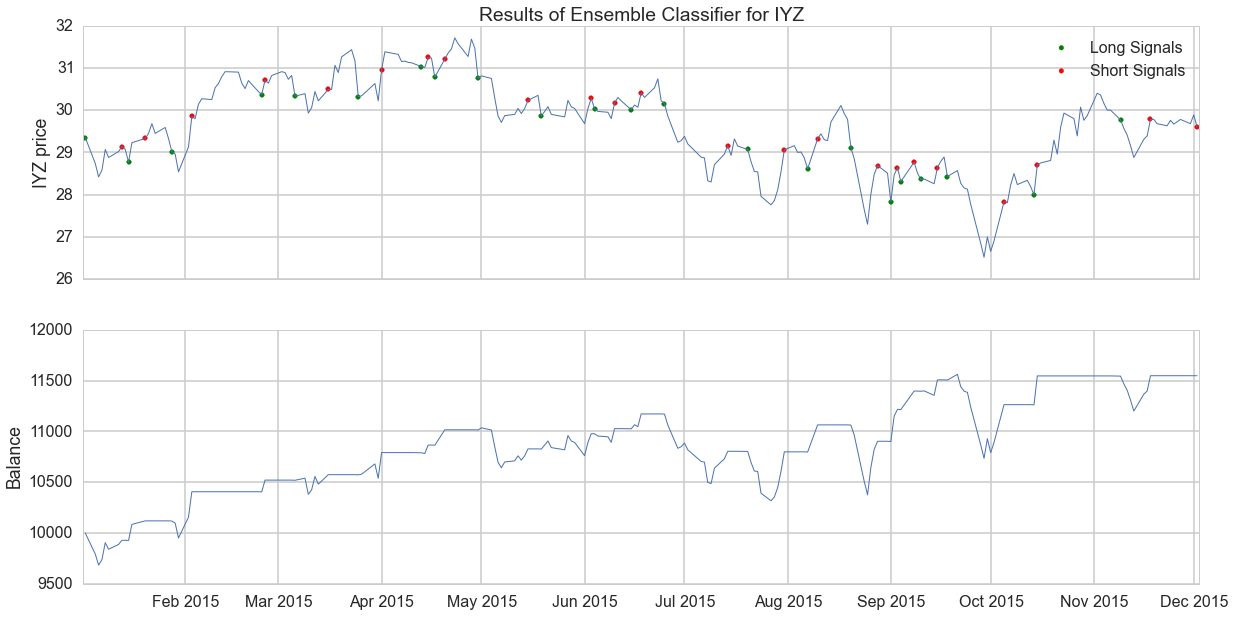

In [30]:
def plot_signal(model, title):
    fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10),sharex=True)
    ax0.plot(df.date[~mask], df.close[~mask], lw=1)
    short_days=zip(*evaluate(model)[5][0])[0]
    short_prices=zip(*evaluate(model)[5][0])[1]
    long_days=zip(*evaluate(model)[5][1])[0]
    long_prices=zip(*evaluate(model)[5][1])[1]
    ax0.scatter(long_days, long_prices, color='g', label="Long Signals") 
    ax0.scatter(short_days, short_prices, color='r', label="Short Signals")
    ax0.legend(frameon=False, loc='upper right')
    ax0.set_title(title)
    ax0.set_ylabel(ticker + " price")
    
    ax1.plot(zip(*evaluate(model)[6])[0], zip(*evaluate(model)[6])[1], lw=1)
    ax1.set_ylabel("Balance")
plot_signal(eclf, 'Results of Ensemble Classifier for '+ticker)

## Part 6 - Visualize the performance across various sectors

#### We re-run our model for the following sectors. 
iShares US Home Construction (ITB) <br>
iShares US Energy (IYE) <br>
iShares US Financials (IYF) <br>
iShares US Healthcare (IYH) <br>
iShares US Industrials (IYJ) <br>
iShares US Basic Materials (IYM) <br>
iShares US Real Estate (IYR) <br>
iShares US Technology (IYW) <br>
iShares US Telecommunications (IYZ)  

In [31]:
# Save results for this ticker to a JSON file
import json
fd = open("ML_results/"+ticker+".json","w")
json.dump(Results, fd)
fd.close()

In [6]:
# Load results from all files
import glob
import json
result_files = glob.glob("./ML_results/*.json")
print result_files
accuracies_all= {}
ROI_diff_all={}
ROI_all={}
for aFile in result_files:
    file_tickr = aFile[13:16]
    #print file_tickr
    with open(aFile, "r") as fd:
        result_dict = json.load(fd)
        models_acc = {}
        models_ROI_diff = {}
        models_ROI = {}
        for key, value in result_dict.iteritems():
            models_acc[key] =  value[1]
            models_ROI_diff[key] =  value[3]-value[2]
            models_ROI[key] =  value[3]
            accuracies_all[file_tickr] =  models_acc
            ROI_diff_all[file_tickr] =  models_ROI_diff
            ROI_all[file_tickr] =  models_ROI
accuracies_all=pd.DataFrame(accuracies_all)
ROI_diff_all=pd.DataFrame(ROI_diff_all)
ROI_all=pd.DataFrame(ROI_all)

['./ML_results/ITB.json', './ML_results/IYE.json', './ML_results/IYF.json', './ML_results/IYH.json', './ML_results/IYJ.json', './ML_results/IYM.json', './ML_results/IYR.json', './ML_results/IYW.json', './ML_results/IYZ.json']


#### Model prediction accuracy

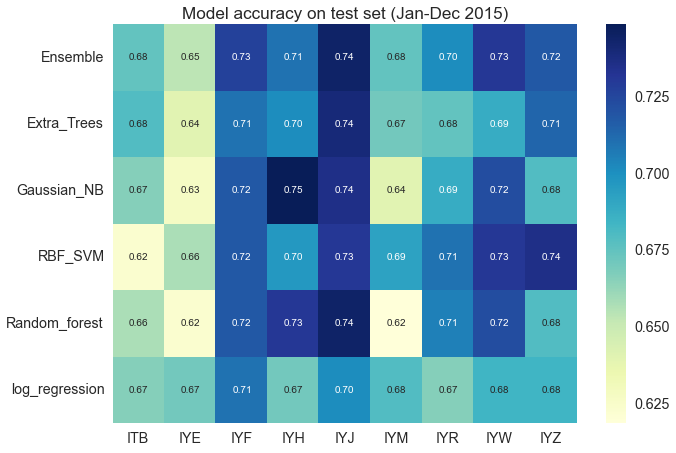

In [7]:
sns.set_context("talk", font_scale=1.1, rc={"lines.linewidth": 2.5})
ax = sns.heatmap(accuracies_all, annot=True, fmt='.2f',cmap="YlGnBu")
ax.set_title("Model accuracy on test set (Jan-Dec 2015)")

#### ROI based on the predicted trading signals

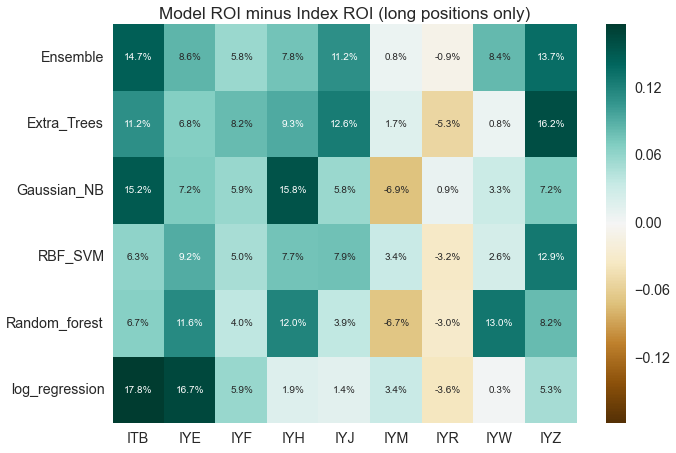

In [8]:
ax2 = sns.heatmap(ROI_diff_all, annot=True, fmt='.1%',cmap="BrBG")
ax2.set_title("Model ROI minus Index ROI (long positions only)")

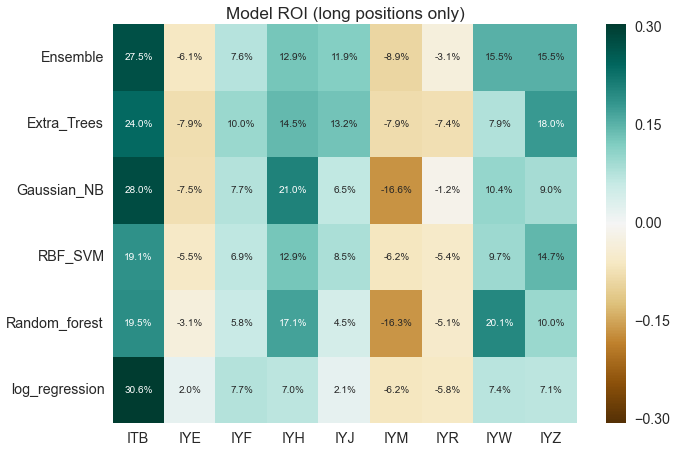

In [9]:
ax2 = sns.heatmap(ROI_all, annot=True, fmt='.1%',cmap="BrBG")
ax2.set_title("Model ROI (long positions only)")

## Part 7 - Final words

### Conclusions
* We beat the market in most sectors!
* For iShares US Home Construction (ITB), our ensemble model outperformed the index ROI by 14.7% !
* On average, we outperformed index ROI by 7.8% among all 9 sectors
* In our model, the trading signal based on moving average outperforms signal based on next-day and next-14-days


### Limitations and Assumptions
* The prediction is less accurate during a sharp down turn in the market
* The calculated ROI is not guaranteed although we included commission in our calculation, but our trading strategy assumes no execution risk, i.e. we assume that Market-On-Close Order is always successfully executed, but this may not be true in real life.


### Future work 

* Implement time series analysis models such as Hidden Markov with sequential Monte Carlo, which our TF Sail brought up during project meeting. We did some initial research and believe they are extremely useful techniques in time series analysis. However they are not implemented in this project due to time constraints, but certainly deserve to be on top of our future work list 


* Use foreign indices such as Nikkei 225 and HANG SENG INDEX as our features--these market open ahead of U.S. and their movement could account for some market sentiment on the up-to-the-minute news. Since overseas exchanges typically have different bank holidays, we would need to re-align the data based on U.S. bank holidays. 


* Implement more advanced feature selection methods such as forward-backward algorithm to reduced the collinearity among features
